<a href="https://colab.research.google.com/github/pd05849/Machine_Learning_Engineering/blob/main/HMW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HMW4: Neural Networks for CIFAR-10 Classification
**Name:** [Pol del Castillo]  
**RIN:** [662116017]  
**Date:** (2025-10-28)


## Problem 1: CIFAR-10 Neural Network Classification



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Numpy version:", np.__version__)

TensorFlow version: 2.19.0
Numpy version: 2.0.2


In [3]:
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data shape: {x_train_full.shape}")
print(f"Training labels shape: {y_train_full.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(class_names)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Number of classes: 10


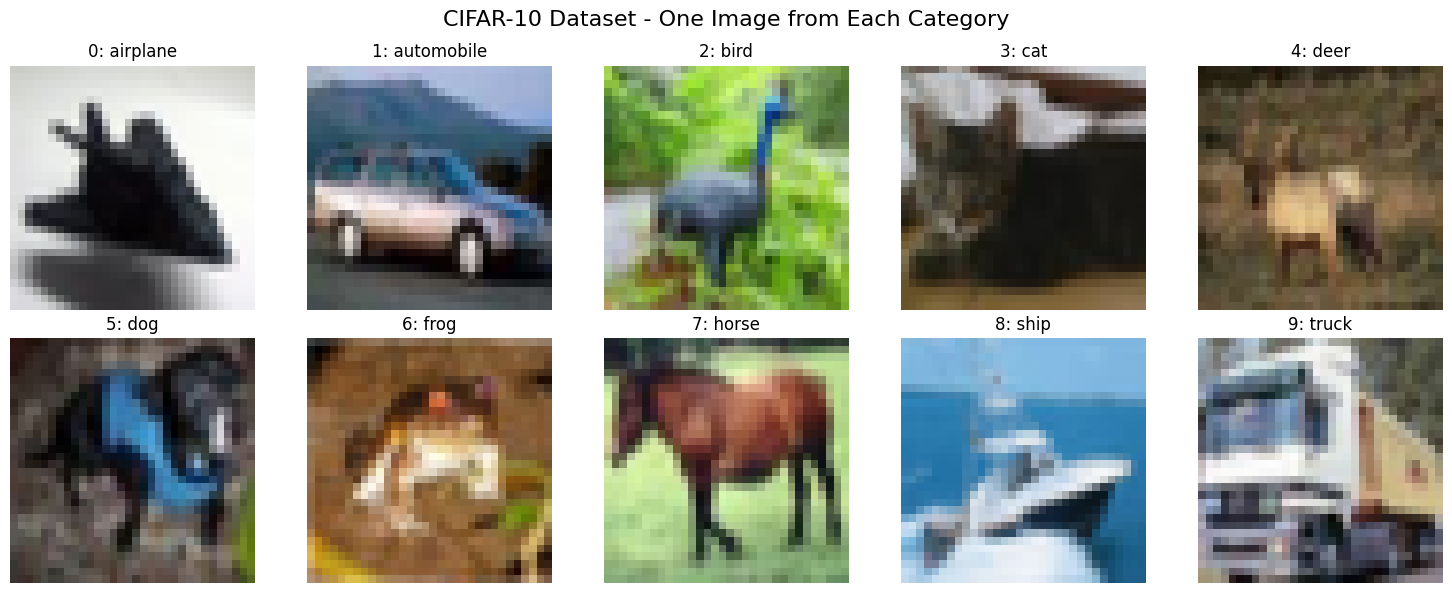

Image dimensions: (32, 32, 3)
Pixel value range: 0 to 255
Data type: uint8


In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('CIFAR-10 Dataset - One Image from Each Category', fontsize=16)

for i in range(10):
    class_idx = np.where(y_train_full.flatten() == i)[0][0]

    row = i // 5
    col = i % 5
    axes[row, col].imshow(x_train_full[class_idx])
    axes[row, col].set_title(f'{i}: {class_names[i]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"Image dimensions: {x_train_full[0].shape}")
print(f"Pixel value range: {x_train_full.min()} to {x_train_full.max()}")

In [5]:
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_full_flat = x_train_full.reshape(x_train_full.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

y_train_full_cat = to_categorical(y_train_full, 10)
y_test_cat = to_categorical(y_test, 10)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full_flat, y_train_full_cat,
    test_size=0.3, random_state=42, stratify=y_train_full
)

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Flattened input dimension: {x_train.shape[1]}")

Training set shape: (35000, 3072)
Validation set shape: (15000, 3072)
Training labels shape: (35000, 10)
Validation labels shape: (15000, 10)
Flattened input dimension: 3072


In [6]:
def create_model(hidden_layers=2, neurons=128, dropout_rate=0.3,
                learning_rate=0.001, activation='relu'):
    model = keras.Sequential()

    model.add(layers.Dense(neurons, activation=activation, input_shape=(3072,)))
    model.add(layers.Dropout(dropout_rate))

    for i in range(hidden_layers - 1):
        model.add(layers.Dense(neurons, activation=activation))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(10, activation='softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

test_model = create_model()
test_model.summary()

Model created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,146 (1.57 MB)

 Trainable params: 411,146 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
param_grid = {
    'hidden_layers': [2, 3],
    'neurons': [64, 128, 256],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.01],
    'activation': ['relu', 'tanh'],
    'batch_size': [32, 64],
    'epochs': [20]
}

Hyperparameter grid defined:
hidden_layers: [2, 3]
neurons: [64, 128, 256]
dropout_rate: [0.2, 0.3, 0.5]
learning_rate: [0.001, 0.01]
activation: ['relu', 'tanh']
batch_size: [32, 64]
epochs: [20]

Total combinations: 144


In [8]:
simplified_grid = {
    'hidden_layers': [2, 3],
    'neurons': [128, 256],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.01]
}

best_score = 0
best_params = {}
results = []

print("Starting hyperparameter grid search...")

total_runs = len(simplified_grid['hidden_layers']) * len(simplified_grid['neurons']) * len(simplified_grid['dropout_rate']) * len(simplified_grid['learning_rate'])
current_run = 0

for hidden_layers in simplified_grid['hidden_layers']:
    for neurons in simplified_grid['neurons']:
        for dropout_rate in simplified_grid['dropout_rate']:
            for learning_rate in simplified_grid['learning_rate']:
                current_run += 1
                print(f"Run {current_run}/{total_runs}: layers={hidden_layers}, neurons={neurons}, dropout={dropout_rate}, lr={learning_rate}")


                model = create_model(hidden_layers=hidden_layers,
                                   neurons=neurons,
                                   dropout_rate=dropout_rate,
                                   learning_rate=learning_rate)

                history = model.fit(x_train, y_train,
                                  batch_size=32,
                                  epochs=15,
                                  validation_data=(x_val, y_val),
                                  verbose=0)

                val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)

                params = {
                    'hidden_layers': hidden_layers,
                    'neurons': neurons,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'val_accuracy': val_accuracy,
                    'val_loss': val_loss
                }
                results.append(params)

                print(f"  Validation Accuracy: {val_accuracy:.4f}")
                if val_accuracy > best_score:
                    best_score = val_accuracy
                    best_params = params.copy()

                print()

print(f"\nBest validation accuracy: {best_score:.4f}")
print("Best parameters:")
for key, value in best_params.items():
    if key not in ['val_accuracy', 'val_loss']:
        print(f"  {key}: {value}")

Starting hyperparameter grid search...
This may take some time...

Run 1/16: layers=2, neurons=128, dropout=0.3, lr=0.001
  Validation Accuracy: 0.1000

Run 2/16: layers=2, neurons=128, dropout=0.3, lr=0.01
  Validation Accuracy: 0.1000

Run 3/16: layers=2, neurons=128, dropout=0.5, lr=0.001
  Validation Accuracy: 0.1000

Run 4/16: layers=2, neurons=128, dropout=0.5, lr=0.01
  Validation Accuracy: 0.1000

Run 5/16: layers=2, neurons=256, dropout=0.3, lr=0.001
  Validation Accuracy: 0.2887

Run 6/16: layers=2, neurons=256, dropout=0.3, lr=0.01
  Validation Accuracy: 0.1000

Run 7/16: layers=2, neurons=256, dropout=0.5, lr=0.001
  Validation Accuracy: 0.1636

Run 8/16: layers=2, neurons=256, dropout=0.5, lr=0.01
  Validation Accuracy: 0.1000

Run 9/16: layers=3, neurons=128, dropout=0.3, lr=0.001
  Validation Accuracy: 0.2920

Run 10/16: layers=3, neurons=128, dropout=0.3, lr=0.01
  Validation Accuracy: 0.1000

Run 11/16: layers=3, neurons=128, dropout=0.5, lr=0.001
  Validation Accuracy

Grid Search Results:
    hidden_layers  neurons  dropout_rate  learning_rate  val_accuracy  \
8               3      128           0.3          0.001      0.292000   
4               2      256           0.3          0.001      0.288733   
12              3      256           0.3          0.001      0.285600   
6               2      256           0.5          0.001      0.163600   
14              3      256           0.5          0.001      0.151267   
3               2      128           0.5          0.010      0.100000   
0               2      128           0.3          0.001      0.100000   
1               2      128           0.3          0.010      0.100000   
7               2      256           0.5          0.010      0.100000   
5               2      256           0.3          0.010      0.100000   
2               2      128           0.5          0.001      0.100000   
9               3      128           0.3          0.010      0.100000   
11              3      128    

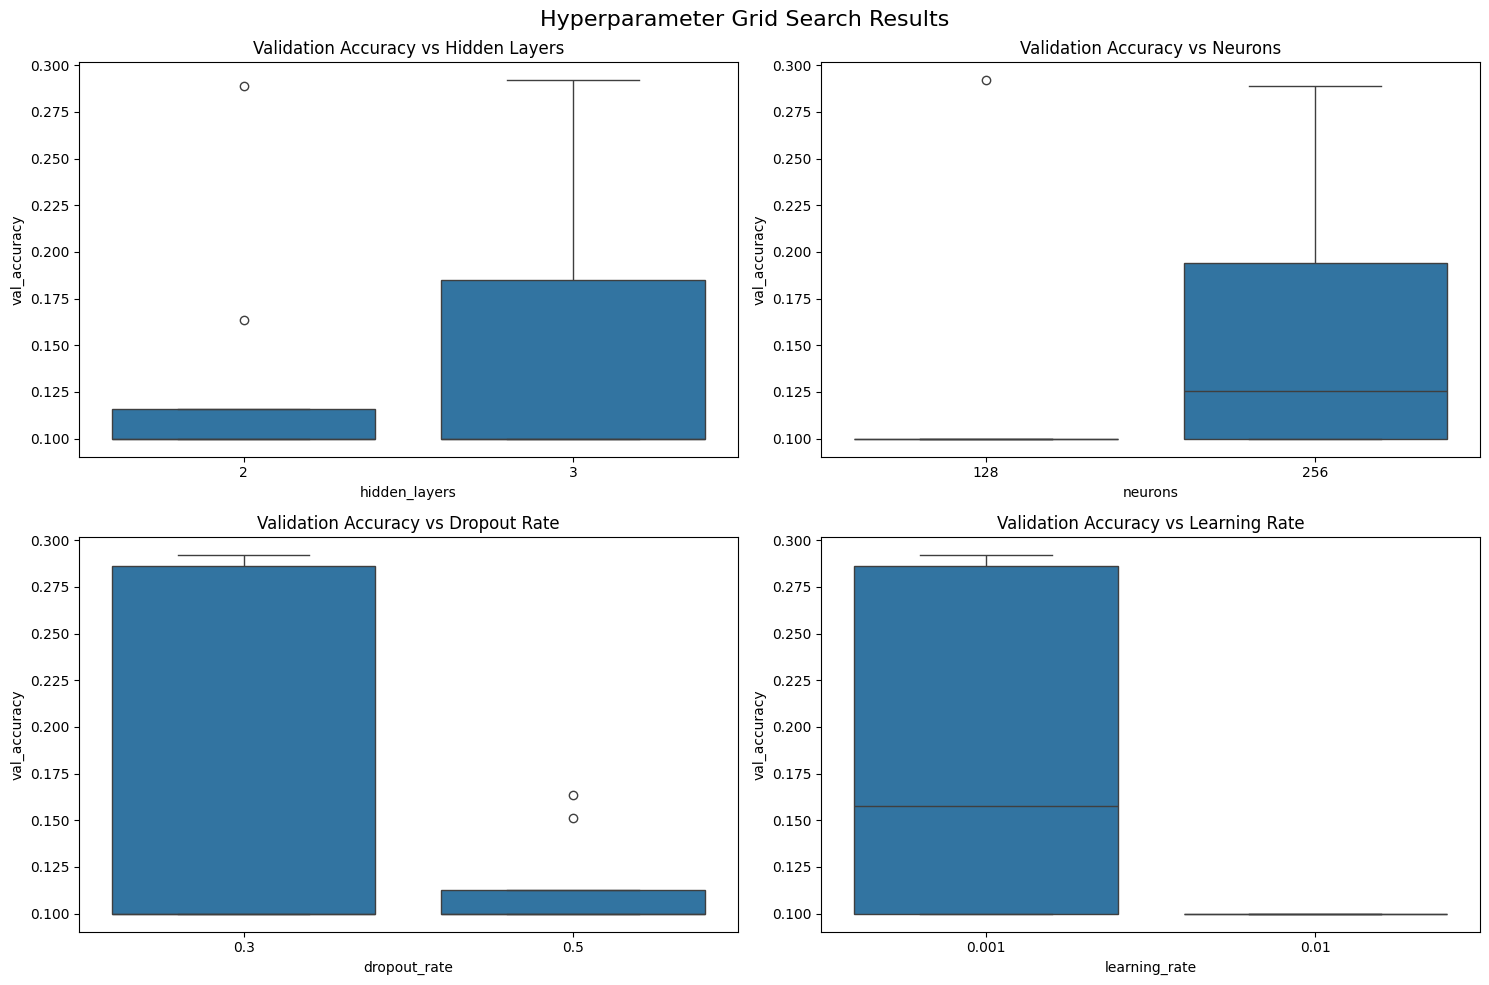

In [9]:
results_df = pd.DataFrame(results)
print("Grid Search Results:")
print(results_df.sort_values('val_accuracy', ascending=False))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Hyperparameter Grid Search Results', fontsize=16)

sns.boxplot(data=results_df, x='hidden_layers', y='val_accuracy', ax=axes[0,0])
axes[0,0].set_title('Validation Accuracy vs Hidden Layers')

sns.boxplot(data=results_df, x='neurons', y='val_accuracy', ax=axes[0,1])
axes[0,1].set_title('Validation Accuracy vs Neurons')

sns.boxplot(data=results_df, x='dropout_rate', y='val_accuracy', ax=axes[1,0])
axes[1,0].set_title('Validation Accuracy vs Dropout Rate')

sns.boxplot(data=results_df, x='learning_rate', y='val_accuracy', ax=axes[1,1])
axes[1,1].set_title('Validation Accuracy vs Learning Rate')

plt.tight_layout()
plt.show()

In [10]:
final_model = create_model(
    hidden_layers=best_params['hidden_layers'],
    neurons=best_params['neurons'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

final_model.summary()

Final model architecture:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 427,658 (1.63 MB)

 Trainable params: 427,658 (1.63 MB)

 Non-trainable params: 0 (0.00 B)


Training final model with best parameters:
  hidden_layers: 3
  neurons: 128
  dropout_rate: 0.3
  learning_rate: 0.001


In [ ]:
print("Training final model...")
final_history = final_model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(x_val, y_val),
    verbose=1
)

print("\nFinal model training completed!")

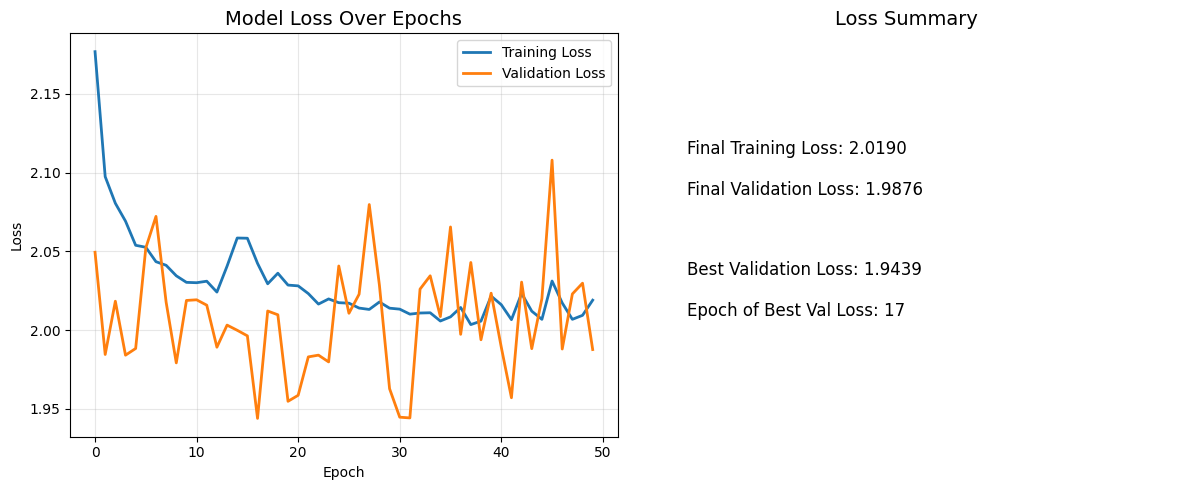

Training Loss: 2.0190
Validation Loss: 1.9876
Best Validation Loss: 1.9439 at epoch 17


In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

final_train_loss = final_history.history['loss'][-1]
final_val_loss = final_history.history['val_loss'][-1]

plt.subplot(1, 2, 2)
plt.text(0.1, 0.7, f'Final Training Loss: {final_train_loss:.4f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f'Final Validation Loss: {final_val_loss:.4f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.4, f'Best Validation Loss: {min(final_history.history["val_loss"]):.4f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.3, f'Epoch of Best Val Loss: {np.argmin(final_history.history["val_loss"]) + 1}', fontsize=12, transform=plt.gca().transAxes)
plt.title('Loss Summary', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Best Validation Loss: {min(final_history.history['val_loss']):.4f} at epoch {np.argmin(final_history.history['val_loss']) + 1}")

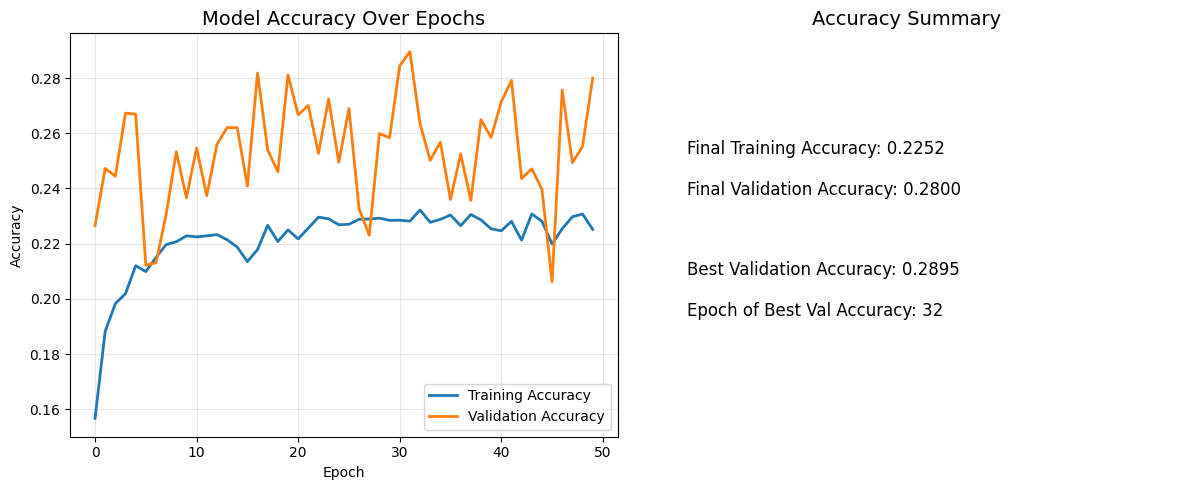

Training Accuracy: 0.2252
Validation Accuracy: 0.2800
Best Validation Accuracy: 0.2895 at epoch 32


In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

final_train_acc = final_history.history['accuracy'][-1]
final_val_acc = final_history.history['val_accuracy'][-1]

plt.subplot(1, 2, 2)
plt.text(0.1, 0.7, f'Final Training Accuracy: {final_train_acc:.4f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f'Final Validation Accuracy: {final_val_acc:.4f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.4, f'Best Validation Accuracy: {max(final_history.history["val_accuracy"]):.4f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.3, f'Epoch of Best Val Accuracy: {np.argmax(final_history.history["val_accuracy"]) + 1}', fontsize=12, transform=plt.gca().transAxes)
plt.title('Accuracy Summary', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Best Validation Accuracy: {max(final_history.history['val_accuracy']):.4f} at epoch {np.argmax(final_history.history['val_accuracy']) + 1}")

QUESTION 2

✅ Dataset loaded successfully!


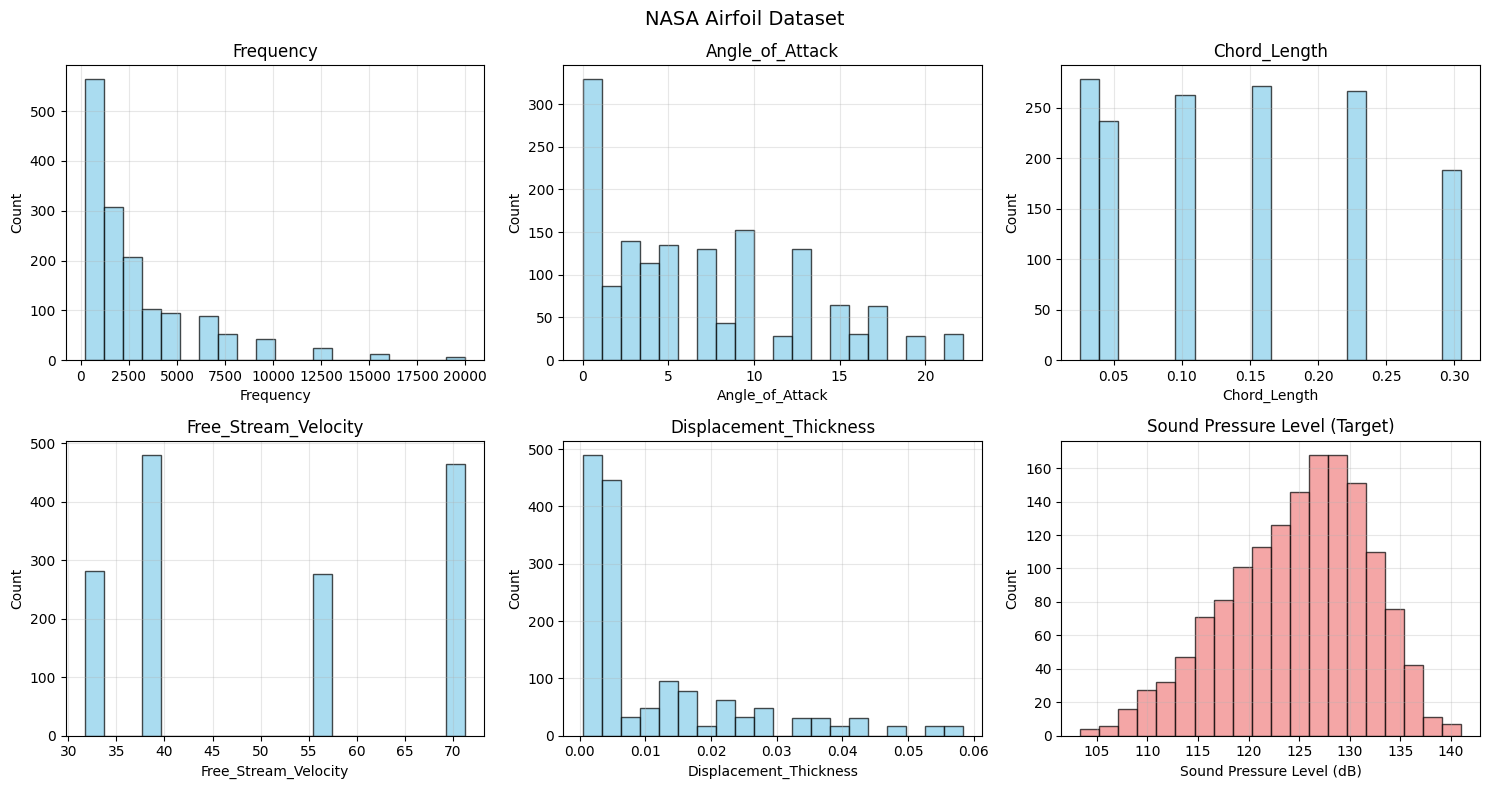

 Dataset Summary:
       Frequency  Angle_of_Attack  Chord_Length  Free_Stream_Velocity  \
count    1503.00          1503.00       1503.00               1503.00   
mean     2886.38             6.78          0.14                 50.86   
std      3152.57             5.92          0.09                 15.57   
min       200.00             0.00          0.03                 31.70   
25%       800.00             2.00          0.05                 39.60   
50%      1600.00             5.40          0.10                 39.60   
75%      4000.00             9.90          0.23                 71.30   
max     20000.00            22.20          0.30                 71.30   

       Displacement_Thickness  Sound_Pressure_Level  
count                 1503.00               1503.00  
mean                     0.01                124.84  
std                      0.01                  6.90  
min                      0.00                103.38  
25%                      0.00                120.19  


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 15498.4434 - mae: 124.2905 - val_loss: 15335.6543 - val_mae: 123.6371
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15044.2686 - mae: 122.4288 - val_loss: 14209.4434 - val_mae: 118.9215
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13490.7373 - mae: 115.7423 - val_loss: 11154.6787 - val_mae: 104.8601
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9735.6406 - mae: 97.2199 - val_loss: 5623.9727 - val_mae: 71.3012
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4106.7002 - mae: 59.2766 - val_loss: 1440.5221 - val_mae: 33.2124
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1052.8695 - mae: 27.5937 - val_loss: 674.7389 - val_mae: 21.2104
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 597.7372 - mae: 20.3265 - val_loss: 482.9133 - val_mae: 17.8024
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 410.7902 - mae: 16.6394 - val_loss: 404.6766 - val_mae: 

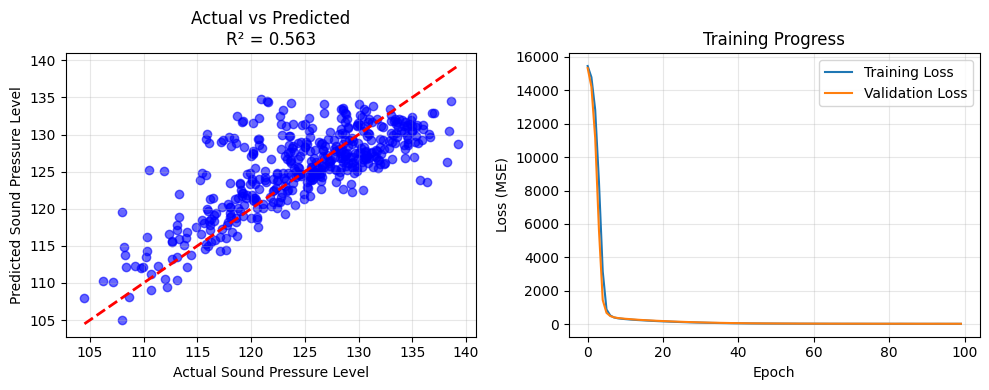

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat"

columns = [
    'Frequency',
    'Angle_of_Attack',
    'Chord_Length',
    'Free_Stream_Velocity',
    'Displacement_Thickness',
    'Sound_Pressure_Level'
]

df = pd.read_csv(url, sep='\t', names=columns)
print("✅ Dataset loaded successfully!")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('NASA Airfoil Dataset', fontsize=14)


features = df.columns[:-1]
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3

    axes[row, col].hist(df[feature], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'{feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Count')
    axes[row, col].grid(True, alpha=0.3)

axes[1, 2].hist(df['Sound_Pressure_Level'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 2].set_title('Sound Pressure Level (Target)')
axes[1, 2].set_xlabel('Sound Pressure Level (dB)')
axes[1, 2].set_ylabel('Count')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print(" Dataset Summary:")
print(df.describe().round(2))



X = df.drop('Sound_Pressure_Level', axis=1)
y = df['Sound_Pressure_Level']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(5,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = y_pred.flatten()

r2 = r2_score(y_test, y_pred)

print(f" R² Score (Coefficient of Determination): {r2:.4f}")

print(f"\n Interpretation:")
print(f"• The model explains {r2*100:.1f}% of the variance in sound pressure level")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sound Pressure Level')
plt.ylabel('Predicted Sound Pressure Level')
plt.title(f'Actual vs Predicted\nR² = {r2:.3f}')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()